### importing the required libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

### importing the data

In [23]:
df = pd.read_csv("Data.csv")

### data cleaning

In [24]:
#renaming the columns in the dataset for convenience
new_columns = {
    'Ship-to ID':'ID',
    'Volume_2019':'total_volume_2019',
    'Volume_2018':'total_volume_2018',
    'sfdc_tier':'city_tier',
    'Product Set':'product_set',
    'Brand':'brand',
    'Sub-Brand':'sub_brand',
    'Pack_Type':'pack_type',
    'Returnalility':'returnability',
    'GTO_2019':'gross_turnover_2019',
    'OnInvoice Discount(LCU)':'on_invoice_discount',
    'OffInvoice Discount(LCU)':'off_invoice_discount',
    'Volume_2019 Product':'product_volume_2019',
    'Tax':'tax',
    'Discount_Total':'total_discount'
}
df.rename(columns = new_columns, inplace = True)

#replacing all '0' (string) values in the poc_image column to 'Mainstream' (mode of the series)
df['poc_image'] = df['poc_image'].replace(to_replace = '0', value = 'Mainstream')
#replacing all null values in the segment column to 'Drink Led' (mode of the series)
df['segment'] = df['segment'].replace(to_replace = ' ', value = 'Drink Led')

for i in range(len(df)):
    #these rows have all numerical values as 0
    #dropping all rows where total_volume_2019 = 0
    if(df['total_volume_2019'][i]==0):
        df=df.drop(i)
    #dropping all rows where the following combination = 0 but other values are non-null
    elif((df['total_discount'][i]==0) & (df['gross_turnover_2019'][i]==0) & (df['on_invoice_discount'][i]==0) & (df['off_invoice_discount'][i]==0) & (df['product_volume_2019'][i]==0) & (df['tax'][i]==0)):
        df=df.drop(i)
    #dropping all rows where both of these = 0 but other values are non-null
    elif((df['product_volume_2019'][i]==0)&(df['gross_turnover_2019'][i]==0)):
        df=df.drop(i)

df.reset_index(inplace = True) #resetting index

#creating a new column - gross turnover per product volume sold in 2019
#the correlation between the two is 1
df['gto/pvol_2019'] = df['gross_turnover_2019']/df['product_volume_2019']
#some product volume values are 0 and makes the final value infinity, so change it to 0
df['gto/pvol_2019'] = df['gto/pvol_2019'].replace([np.inf, -np.inf], 0)
#creating a new column - total volume sold in 2019 per total volume sold in 2019
#the correlation between the two is 0.96
df['tvol18/tvol19'] = df['total_volume_2018']/df['total_volume_2019']
#outliers
df=df.drop(3133)
df=df.drop(38106)
df.reset_index(inplace = True) #resetting index
df.drop(df.columns[[0, 1]], axis = 1, inplace = True) #resetting index creates new useless indices

#filling empty missing values
for i in range(len(df)):
    if(df['gross_turnover_2019'][i]==0):
        df.at[i, 'gross_turnover_2019']=df['product_volume_2019'][i]*df['gto/pvol_2019'].mean()
    elif(df['total_volume_2018'][i]==0):
        df.at[i, 'total_volume_2018']=df['total_volume_2019'][i]*df['tvol18/tvol19'].mean()
        
#creating a new column - product volume sold for every rupee spent by POC in 2019
df['pvol_2019/gto'] = df['product_volume_2019']/df['gross_turnover_2019']
df=df.drop(25695) #outliers
df.reset_index(inplace = True) #resetting index
df.drop(df.columns[0], axis = 1, inplace = True)

#filling empty missing values
for i in range(len(df)):        
    if(df['product_volume_2019'][i]==0):
        df.at[i, 'product_volume_2019']=df['gross_turnover_2019'][i]*df['pvol_2019/gto'].mean()

#dropping the newly created columns
#df.drop(['gto/pvol_2019','tvol18/tvol19','pvol_2019/gto'], axis = 1, inplace = True)

#creating new columns - tax per gross turnover in 2019
df['tax/gto']=(df['tax']/df['gross_turnover_2019'])*100
#total discount given per gross turnover in 2019
df['tdisc/gto']=(df['total_discount']/df['gross_turnover_2019'])*100
df['gto-tax']=(df['gross_turnover_2019']-df['tax'])
df['tdisc/gtx']=(df['total_discount']/df['gto-tax'])*100


#dropping outliers
df=df.drop(25640)
df=df.drop(34940)
df=df.drop(39053)
df=df.drop(34112)
df=df.drop(11722)
df=df.drop(18253)
df=df.drop(39247)
df=df.drop(11028)
df=df.drop(32951)
df.reset_index(inplace = True) #resetting index
df.drop(df.columns[0], axis = 1, inplace = True)

#dropping outliers (data that doesnt make sense logically)
df.drop(df[(df['tax/gto']>70)|(df['tax/gto']<0)].index, inplace=True)
df.drop(df[df['gross_turnover_2019']>9*(10**5)].index, inplace=True)
df.drop(df[df['pvol_2019/gto']<0].index, inplace=True)
df.drop(df[df['gto/pvol_2019']>20000].index, inplace=True)
df.drop(df[(df['tdisc/gto']<0)|(df['tdisc/gto']>=75)].index, inplace=True)
df.drop(df[df['ID']==29054511].index, inplace=True)
df.drop(df[(df['tax']<0)|(df['gross_turnover_2019']<0)|(df['product_volume_2019']<0)|(df['on_invoice_discount']<0)|(df['off_invoice_discount']<0)|(df['total_discount']<0)|(df['total_volume_2019']<0)|(df['total_volume_2018']<0)].index, inplace=True)
df.drop(df[(df['tax']>40000)|(df['gross_turnover_2019']>400000)|(df['product_volume_2019']>1750)].index, inplace=True)
df.drop(['gto/pvol_2019','tvol18/tvol19','pvol_2019/gto','pvol_2019/gto'], axis = 1, inplace = True)

### finding correlation among the columns in the data

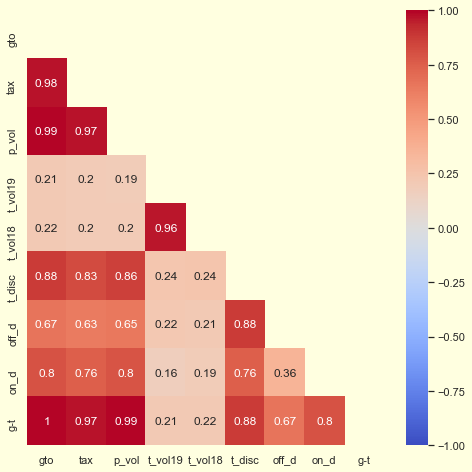

In [25]:
plt.figure(figsize=(8, 8))
sns.set(rc={'axes.facecolor':'lightyellow', 'figure.facecolor':'lightyellow'})
mapColumnsDataframe = df[['gross_turnover_2019','tax','product_volume_2019','total_volume_2019','total_volume_2018','total_discount', 'off_invoice_discount', 'on_invoice_discount','gto-tax']].copy()
mapColumnsDataframe.rename(columns = {
    'gross_turnover_2019':'gto',
    'product_volume_2019':'p_vol',
    'total_volume_2019':'t_vol19',
    'total_volume_2018':'t_vol18',
    'total_discount':'t_disc',
    'off_invoice_discount':'off_d',
    'on_invoice_discount':'on_d',
    'gto-tax':'g-t'
}, inplace = True)
corr = mapColumnsDataframe.corr()
matrix = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm', mask=matrix);

## data preprocessing

In [26]:
#dropping inessential features
df.drop(['tdisc/gtx','tax/gto','tdisc/gto','product_set'], axis = 1, inplace = True)

#label encoding city tier
df["city_tier"].replace({"Tier 0": 1, "Tier 1": 2, "Tier 2": 4}, inplace=True) #values are ratio of frequency

#dummy encoding features with low count
poc_image = pd.get_dummies(df["poc_image"], drop_first = True)
segment = pd.get_dummies(df["segment"], drop_first = True)
pack_type = pd.get_dummies(df["pack_type"], drop_first = True)
returnability = pd.get_dummies(df["returnability"], drop_first = True)

#dropping the actual columns and replacing with the above encoded columns
df.drop(["poc_image","segment","pack_type","returnability"], axis = 1, inplace = True)
df = pd.concat([df, poc_image, segment, pack_type, returnability], axis = 1)

#one hot encoding the most frequent values

#subsegment top 6
subsegment_c = [x for x in df["sub_segment"].value_counts().sort_values(ascending=False).head(6).index]
#brand top 6
brand_c = [x for x in df["brand"].value_counts().sort_values(ascending=False).head(6).index]
#sub_brand top 8
subbrand_c = [x for x in df["sub_brand"].value_counts().sort_values(ascending=False).head(8).index]
#province top 10 (total are 11, (similar to drop first, all are included))
province_c = [x for x in df["province"].value_counts().sort_values(ascending=False).head(10).index]

#function to create one hot encoding columns
def one_hot_top_x(df, variable, top_x_labels):
    for label in top_x_labels:
        df[variable+ "_"+ label] = np.where(df[variable]==label,1,0)
        
one_hot_top_x(df,"sub_segment",subsegment_c)
one_hot_top_x(df,"brand",brand_c)
one_hot_top_x(df,"sub_brand",subbrand_c)
one_hot_top_x(df,"province",province_c)

#dropping inessential columns again
df.drop(["sub_segment","brand","sub_brand","province"], axis = 1, inplace = True)
df.drop("ID",axis=1,inplace=True)

#exporting final dataset
df.to_csv("Data_Encoded.csv", index= False)

## creating a profile report html file

In [31]:
#from pandas_profiling import ProfileReport
#prof = ProfileReport(df)
#prof.to_file('profile_report.html')